# Solution for the Predict Prices task

### Task 1: Load the dataset and calculate the average price and estimated owners, and output to a file named output_1.csv

In [1]:
import math
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.mixture import GaussianMixture
import pandas as pd
from typing import Any, Tuple
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import csv 
import joblib
import torch
import torch.nn as nn
import torch
from sklearn.preprocessing import StandardScaler

#  Try to use a method for normalizing the data reusable across training and prediction
# In this example, we do standardization on a single column.
# Global scaler for standardization
scaler = StandardScaler()
def normalize_data(df: pd.DataFrame, columns: list, fit: bool = True) -> pd.DataFrame:
    if fit:
        # fits a scaler and transforms the data (used when training)
        df[columns] = scaler.fit_transform(df[columns])
    else:
        # only transforms the data (during inference), reuse the learned scaler above
        df[columns] = scaler.transform(df[columns])
    return df
    

# This function loads the dataset from the given path and returns the features and target variables, as well as the number of men, average duration of activity, 
# and number of senior users. 
# During evaluation set, the is_eval_dataset flag should be set to True
# During the second task, the is_handball_dataset should be set to True
# Load dataset and preprocess features using pandas
def load_data(dataset_path: str, is_eval_dataset=False, is_handball_dataset=False) -> Tuple[Any, Any, Any, int, float, int]:
    columns_to_drop = ["UserID"]
    
    # Load dataset into a pandas DataFrame
    df = pd.read_csv(dataset_path, encoding="utf-8").drop(columns=columns_to_drop, errors='ignore')


    # Compute no. of males (after facterization male becomes 0 and female becomes 1)
    if not(is_handball_dataset):
        df['Gender'], _ = pd.factorize(df['Gender'])
        no_males = len(df[df['Gender'] == 0])
    else:
        no_males = len(df)
                   
    # Compute average duration of activity
    avg_duration = round(df["Duration"].mean(), 2)

    # Compute no. of senior citizens
    no_senior_users = len(df[df['Age'] >= 75])

    # Prepare data for training 
    # Separate features (X) and target (y)
    X = df.drop(columns=["Calories"], errors='ignore')
    y = df["Calories"].values if not is_eval_dataset else [0] * len(df)

    return df, X, y, no_males, avg_duration, no_senior_users

In [2]:
# Load the full dataset
dataset_loaded, X, y, no_males, avg_duration, no_senior_users = load_data("dataset_train.csv")

# Output to a file named output_0.csv the number of samples, number of males, average duration
# and number of senior users
df = pd.DataFrame({
        "Samples": [len(dataset_loaded)],
        "No. Males": [no_males],
        "Average Duration": [avg_duration],
        "SeniorUsers": [no_senior_users]
    })
df.to_csv("output_0.csv", index=False)


## Do some data analysis, try to use statistics and plots

### Num rows with missing data: 0


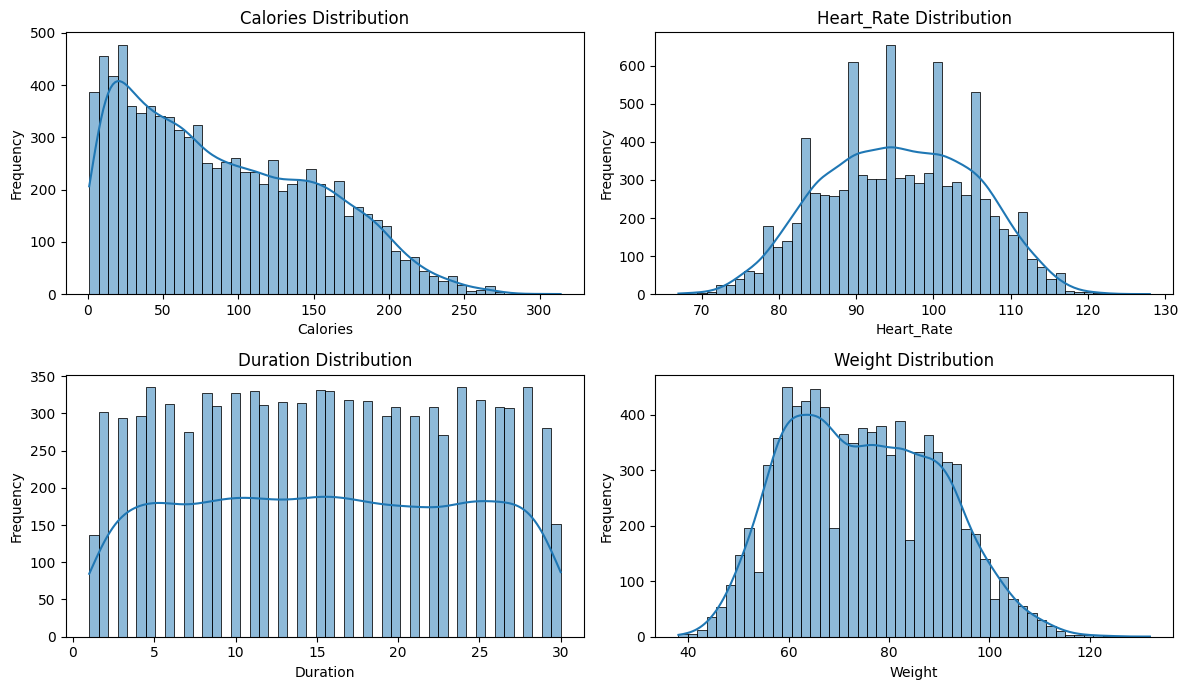

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Checking for na rows, just to be sure
missing_rows = dataset_loaded[dataset_loaded.isna().any(axis=1)]
print(f"### Num rows with missing data: {len(missing_rows.head())}")

# Function to plot data for multiple columns
def plot_data(df: pd.DataFrame):
    plt.figure(figsize=(12, 7))
    
    plots = [
        ("Calories", "Calories Distribution", "Calories", "Frequency"),
        ("Heart_Rate", "Heart_Rate Distribution", "Heart_Rate", "Frequency"),
        ("Duration", "Duration Distribution", "Duration", "Frequency"),
        ("Weight", "Weight Distribution", "Weight", "Frequency"),
    ]
    
    for i, (column, title, xlabel, ylabel) in enumerate(plots, 1):
        plt.subplot(2, 2, i)
        
        sns.histplot(df[column], bins=50, kde=True, color='green' if column == "Positive" else 'red' if column == "Negative" else None)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    plt.tight_layout()
    plt.show()

plot_data(dataset_loaded)

Weight     27.0
Height    132.5
Age       -14.0
dtype: float64 Weight    123.0
Height    216.5
Age        98.0
dtype: float64


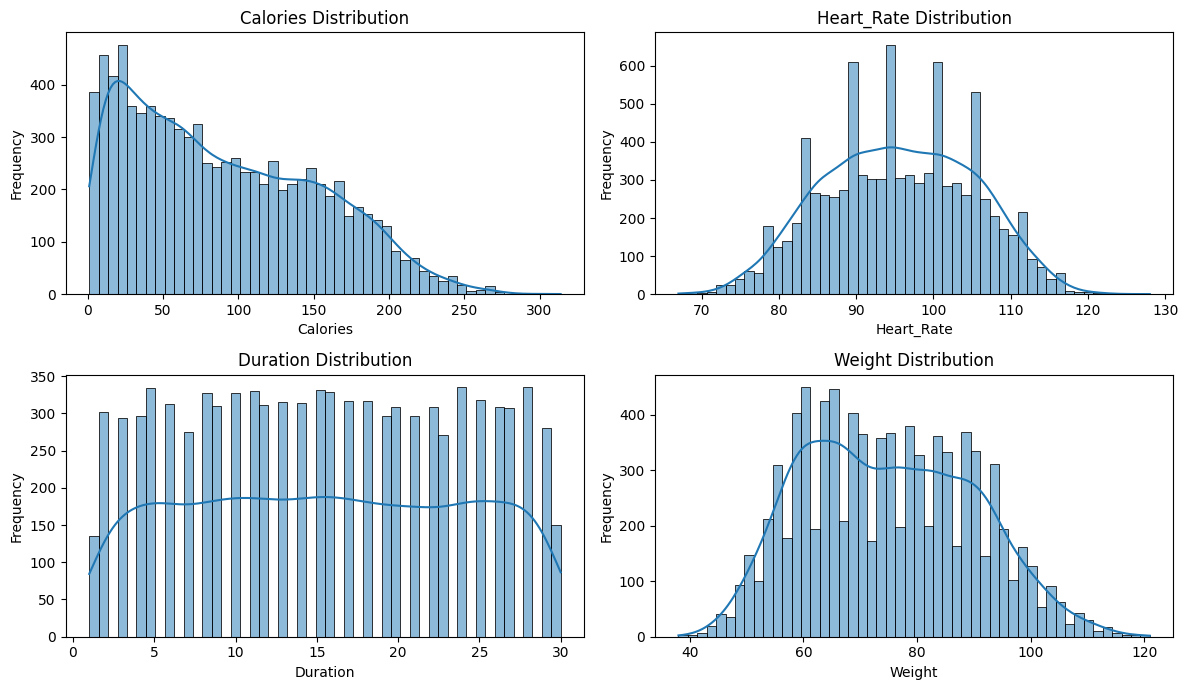

In [4]:
## We see some outliers in both prices and estimated owners
# Step 1: remove outliers using IQR (Interquartile) Method

# Function to remove outliers based on IQR
def remove_outliers(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    Q1 = df[columns].quantile(0.25)
    Q3 = df[columns].quantile(0.75)
    IQR = Q3 - Q1
    
    # Define bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    print(lower_bound, upper_bound)
    
    # Filter out outliers
    df_filtered = df[~((df[columns] < lower_bound) | (df[columns] > upper_bound)).any(axis=1)]
    return df_filtered

dataset_loaded_filtered = remove_outliers(dataset_loaded, ["Weight", "Height", "Age"])


plot_data(dataset_loaded_filtered)

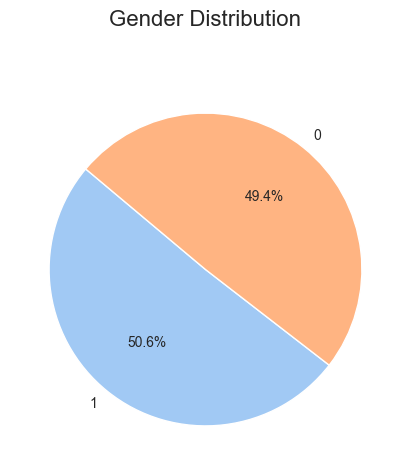

In [5]:
# Define Seaborn style
sns.set_style("whitegrid")


column = 'Gender'
category_counts = dataset_loaded[column].value_counts()
colors = sns.color_palette('pastel', len(category_counts))

plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=colors)

# Set overall title
plt.suptitle("Gender Distribution", fontsize=16)

# Adjust layout to fit everything nicely
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Show plot
plt.show()

### Train your model - Play as you like from here to get the best AI model ####

In [6]:
import numpy as np
from collections import defaultdict

# Convert the dataset to a pandas DataFrame for easier manipulation in other libraries
# y is transformed to an array
X = pd.DataFrame(X)
y = pd.Series(y).ravel()

# Define a simple NN for prediction
class SimplePredictionNetwork(nn.Module):
    def __init__(self, input_size):
        super(SimplePredictionNetwork, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.model(x)
    
def normalize_data(df: pd.DataFrame) -> pd.DataFrame:
    df_normalized = df.copy()
    for column in df.select_dtypes(include=['number']).columns:
        df_normalized[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    return df_normalized

# The advanced solution train different models and compares them
def train_model(X: pd.DataFrame, y: pd.Series, model_type: str) -> Any:

    # More pre-processing first
    X = normalize_data(X)
    
    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Select model based on input type
    if model_type == "linear_regression":
        model = LinearRegression()
    elif model_type == "decision_tree":
        model = DecisionTreeRegressor(random_state=42)
    elif model_type == "random_forest":
        model = RandomForestRegressor(n_estimators=100, random_state=42)
    elif model_type == "gradient_boosting": 
        model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    elif model_type == "deep_learning":
        model = SimplePredictionNetwork(X_train.shape[1])
    else:
        raise ValueError("Unsupported model type")
    
    # Train the model. scikit APIs are light
    if model_type not in ["deep_learning"]:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    elif model_type == "deep_learning":
        # Define the loss and optimizer
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.L1Loss()
        
        # Convert input values to tensors
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

        # Training for 10000 epochs
        for epoch in range(5000):  
            optimizer.zero_grad()
            y_trainpred_tensor = model(X_train_tensor)                
            loss = criterion(y_trainpred_tensor, y_train_tensor)
            loss.backward()
            optimizer.step()
        
        # Get the prediction values on the test set
        y_pred = model(X_test_tensor).detach().numpy()
    else: 
        assert False, "Model not recognized"
    
    # Calculate the mean absolute error for regression models
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Mean Absolute Error ({model_type}):", mae)
    
    return model


C:\Users\Mano\AppData\Local\Temp\ipykernel_34824\3748615351.py:7: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = pd.Series(y).ravel()


In [7]:
# Train and save different models
trained_model = defaultdict(None)
for model_name in ["linear_regression", "decision_tree", "random_forest", "gradient_boosting", "deep_learning"]:
    trained_model[model_name] = train_model(X, y, model_name)
    joblib.dump(trained_model, f"trained_model_{model_name}.pkl")

Mean Absolute Error (linear_regression): 8.458525852782174
Mean Absolute Error (decision_tree): 4.433333333333334
Mean Absolute Error (random_forest): 2.5167888888888887
Mean Absolute Error (gradient_boosting): 2.6950236856350274
Mean Absolute Error (deep_learning): 0.614617220626937


### Task 2: Load our best model and the evaluation dataset, and make predictions, and output to a file named output_1.csv

In [8]:
def predict_calories(model_library: Any, model_key: str, dataset_path: str) -> pd.DataFrame:
    
    model = model_library[model_key]
    # Load the evaluation dataset
    _, X_eval, _, _, _, _ = load_data(dataset_path, is_eval_dataset=True, is_handball_dataset=False)
    
    X_eval = pd.DataFrame(X_eval)

    X_eval = normalize_data(X_eval)
    
    # Make predictions
    if model_key == 'deep_learning':
        X_eval = torch.tensor(X_eval.values, dtype=torch.float32)
        y_pred = model(X_eval).detach().numpy()
        y_pred = y_pred[:, 0]
    else:
        y_pred = model.predict(X_eval)
    
    # Save the predictions to a file named output_2.csv with a single column of predictions
    # no pandas 
    with open("output_1.csv", "w") as file:
        # Write the header
        file.write("Calories\n")
        # Write the predictions
        for pred in y_pred:
            file.write(str(pred) + "\n")

# After studying performance of multiple models, we discovered that on the setup we made so far, the random_forest is the best so use it as predictor
#my_saved_model = joblib.load("trained_model.pkl") # How to load it
predict_calories(trained_model, "deep_learning", "task1_dataset_eval.csv")

### Task 3 - Create model for the handball man team

In [9]:
_, X, y, _, _, _ = load_data("dataset_train.csv", is_handball_dataset=False)
X_handball = X[X['Gender'] == 0]
X_handball = X_handball.drop(columns=['Gender'])
y_handball = pd.Series(y).loc[X_handball.index].ravel()

trained_model_handball = defaultdict(None)
for model_name in ["linear_regression", "decision_tree", "random_forest", "gradient_boosting", "deep_learning"]:
    trained_model_handball[model_name] = train_model(X_handball, y_handball, model_name)
    joblib.dump(trained_model_handball, f"trained_model_handball_{model_name}.pkl")

Mean Absolute Error (linear_regression): 8.588955616196492
Mean Absolute Error (decision_tree): 5.059617547806524


C:\Users\Mano\AppData\Local\Temp\ipykernel_34824\3227265795.py:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y_handball = pd.Series(y).loc[X_handball.index].ravel()


Mean Absolute Error (random_forest): 2.4442969628796396
Mean Absolute Error (gradient_boosting): 2.271241337433213
Mean Absolute Error (deep_learning): 1.549318009474146


In [12]:
def predict_calories_handball(model_library: Any, model_key: str, dataset_path: str) -> pd.DataFrame:
    
    model = model_library[model_key]
    # Load the evaluation dataset
    _, X_eval, _, _, _, _ = load_data(dataset_path, is_handball_dataset=True, is_eval_dataset=True)
    
    X_eval = pd.DataFrame(X_eval)

    X_eval = normalize_data(X_eval)
    
    # Make predictions
    if model_key == 'deep_learning':
        X_eval = torch.tensor(X_eval.values, dtype=torch.float32)
        y_pred = model(X_eval).detach().numpy()
        y_pred = y_pred[:, 0]
    else:
        y_pred = model.predict(X_eval)
    
    # Save the predictions to a file named output_2.csv with a single column of predictions
    # no pandas 
    with open("output_2.csv", "w") as file:
        # Write the header
        file.write("Calories\n")
        # Write the predictions
        for pred in y_pred:
            file.write(str(pred) + "\n")

predict_calories_handball(trained_model_handball, "deep_learning", "task2_dataset_eval.csv")
